<a href="https://colab.research.google.com/github/TariqAlhathloul/Time-Series-Forecasting-Project/blob/main/WorkSpace/traffic_Counts_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Description: This dataset includes real-time and historical traffic congestion data from Chicago, including traffic flow, speed, and incident reports. It's valuable for studying traffic patterns in urban environments.

## Dataset Overview

#### 1. `ID`: A unique identifier for each traffic count record.

#### 2. `Traffic Volume Count Location Address`: The address where the traffic volume was recorded.

#### 3. `Street`: The street name where the traffic count was taken.

#### 4. `Date of Count`: The date on which the traffic count was recorded.

#### 5. `Total Passing Vehicle Volume`: The total number of vehicles that passed the location during the count period.

#### 6. ` Vehicle Volume By Each Direction of Traffic`: The vehicle count divided by direction (e.g., East Bound, West Bound).

#### 7. `Latitude`: The latitude coordinate of the traffic count location.

#### 8. `Longitude`: The longitude coordinate of the traffic count location.

#### 9. `Location`: The geographic location as a tuple of latitude and longitude.

Check out the [City of Chicago Traffic Data](https://www.chicago.gov/city/en/depts/cdot/dataset/average_daily_trafficcounts.html) for more information.


[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/username/repository/blob/main/notebook.ipynb)

## import libraries

In [2]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler

import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM, Bidirectional

import math
from sklearn.metrics import mean_squared_error

## Load the data

In [3]:
df_traffic = pd.read_csv("/content/Average_Daily_Traffic_Counts_-_2006.csv")

### Change the datatype of the `Date of Count` from object to datetime.
### drop`ID` and `Location`.
### Set new column `Date` as index.
### sort the values in the dataframe based on the `date`.

In [4]:
df_traffic['Date'] = pd.to_datetime(df_traffic['Date of Count'], format='%m/%d/%Y')
df_traffic.drop(columns=['ID ', 'Location'], axis=1, inplace=True)
df_traffic.set_index('Date', inplace=True)
df_traffic = df_traffic.sort_values(by='Date')
df = df_traffic.copy()


## convert to numpy array

In [5]:
traffic_volume = df[['Total Passing Vehicle Volume']]

## Preprocessing

In [6]:
min_max = MinMaxScaler(feature_range=(0, 1))
traffic_scaled = min_max.fit_transform(traffic_volume)

## Data splitting

In [7]:
train_size = int(0.7 * len(traffic_scaled))
test_size = len(traffic_scaled) - train_size

train_data = traffic_scaled[:train_size]
test_data = traffic_scaled[train_size:]

In [8]:
print(train_data.shape)
print(test_data.shape)

(895, 1)
(384, 1)


## function to prepare the train and test data for modeling

In [9]:
def prepare_data(data, time_steps):
  X, Y = [], []
  for i in range(len(data) - time_steps):
    X.append(data[i: i + time_steps])
    Y.append(data[i + time_steps])

  return np.array(X), np.array(Y)

In [10]:
time_step = 30

X_train, y_train = prepare_data(data=train_data, time_steps=time_step)
X_test, y_test = prepare_data(data=test_data, time_steps=time_step)

In [11]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(865, 30, 1)
(865, 1)
(354, 30, 1)
(354, 1)


In [12]:
X_train = np.reshape(X_train, (X_train.shape[0],X_train.shape[1],1))

In [13]:
model = Sequential()

model.add(LSTM(units=32, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(Dropout(0.2))

model.add(LSTM(units=32))
model.add(Dropout(0.2))

model.add(Dense(units=1))

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


## compile the model

In [14]:
model.compile(
    optimizer='rmsprop',
    loss='mean_squared_error',
    metrics=['mae']
)

## callbacks

In [15]:
callbacks = [
    keras.callbacks.ModelCheckpoint("Models/LSTM_Model.keras", save_best_only=True)
]

## LSTM model summary

In [16]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 30, 32)              │           4,352 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 30, 32)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 32)                  │           8,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 12,705 (49.63 KB)

 Trainable params: 12,705 (49.63 KB)

 Non-trainable params: 0 (0.00 B)

## fit the model

In [17]:
history = model.fit(
    X_train,
    y_train,
    epochs=100,
    batch_size=32,
    callbacks=callbacks,
    validation_split=0.2,
    verbose=1
)

Epoch 1/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 7s 60ms/step - loss: 0.0110 - mae: 0.0750 - val_loss: 0.0065 - val_mae: 0.0516
Epoch 2/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 0.0069 - mae: 0.0561 - val_loss: 0.0066 - val_mae: 0.0554
Epoch 3/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.0069 - mae: 0.0548 - val_loss: 0.0065 - val_mae: 0.0520
Epoch 4/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0053 - mae: 0.0543 - val_loss: 0.0065 - val_mae: 0.0520
Epoch 5/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0061 - mae: 0.0558 - val_loss: 0.0075 - val_mae: 0.0653
Epoch 6/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.0075 - mae: 0.0586 - val_loss: 0.0065 - val_mae: 0.0546
Epoch 7/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0052 - mae: 0.0531 - val_loss: 0.0065 - val_mae: 0.0508
Epoch 8/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 0.0072 - mae: 0.0571 - val_loss: 0.0065 - val_mae: 0.0523
Epoch 9/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - lo

## Predications

In [18]:
## plot predications

predications = model.predict(X_test)
predications = min_max.inverse_transform(predications)
y_test = min_max.inverse_transform(y_test)



12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step


In [21]:
score = np.sqrt(mean_squared_error(y_test, predications))
print('Test Score: %.2f RMSE' % (score))


Test Score: 10905.69 RMSE


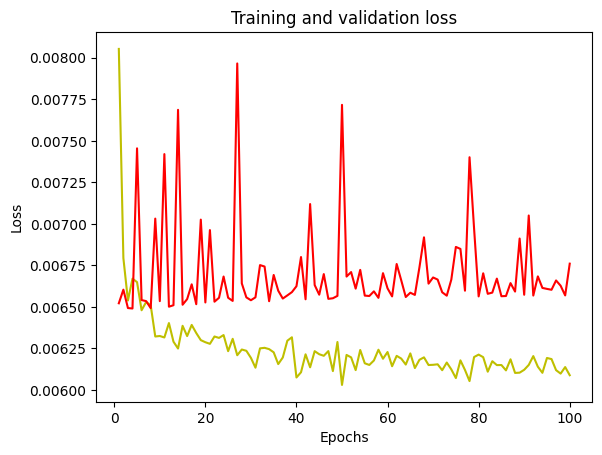

In [22]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

In [23]:
history.history.keys()

dict_keys(['loss', 'mae', 'val_loss', 'val_mae'])

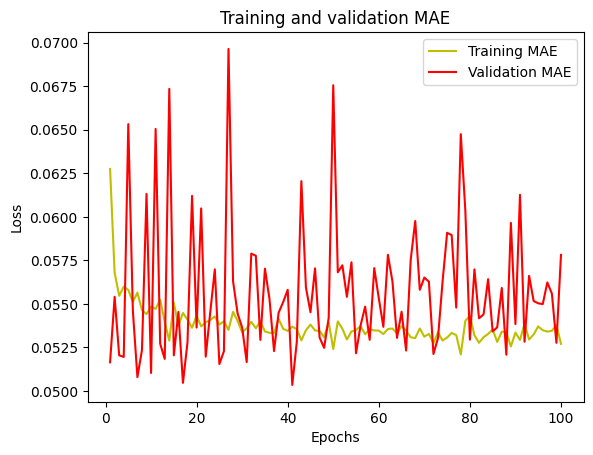

In [24]:
mea = history.history['mae']
val_mea = history.history['val_mae']

epochs = range(1, len(loss) + 1)

plt.plot(epochs, mea, 'y', label='Training MAE')
plt.plot(epochs, val_mea, 'r', label='Validation MAE')
plt.title('Training and validation MAE')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

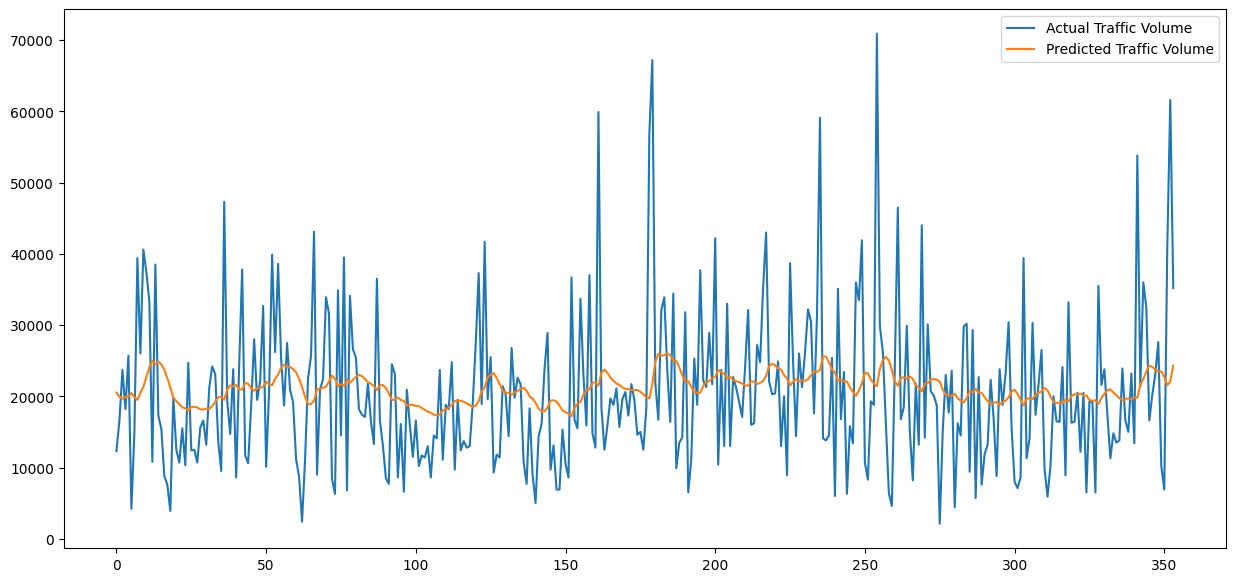

In [25]:
plt.figure(figsize=(15, 7))
plt.plot(y_test, label='Actual Traffic Volume')
plt.plot(predications, label='Predicted Traffic Volume')
plt.legend()
plt.show()